In [5]:
import scipy.io as scio
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']
# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]
sampled_data = first_channel[:50000:10]
len(sampled_data)

5000

Epoch 1/200
118/118 [==============================] - 43s 146ms/step - loss: 0.1749 - val_loss: 0.1689 - lr: 3.0000e-04
Epoch 2/200
118/118 [==============================] - 15s 124ms/step - loss: 0.1710 - val_loss: 0.1660 - lr: 3.0000e-04
Epoch 3/200
118/118 [==============================] - 13s 107ms/step - loss: 0.1687 - val_loss: 0.1643 - lr: 3.0000e-04
Epoch 4/200
118/118 [==============================] - 12s 102ms/step - loss: 0.1673 - val_loss: 0.1633 - lr: 3.0000e-04
Epoch 5/200
118/118 [==============================] - 12s 103ms/step - loss: 0.1665 - val_loss: 0.1628 - lr: 3.0000e-04
Epoch 6/200
118/118 [==============================] - 11s 98ms/step - loss: 0.1661 - val_loss: 0.1625 - lr: 3.0000e-04
Epoch 7/200
118/118 [==============================] - 11s 94ms/step - loss: 0.1658 - val_loss: 0.1623 - lr: 3.0000e-04
Epoch 8/200
118/118 [==============================] - 11s 96ms/step - loss: 0.1657 - val_loss: 0.1622 - lr: 3.0000e-04
Epoch 9/200
118/118 [==============

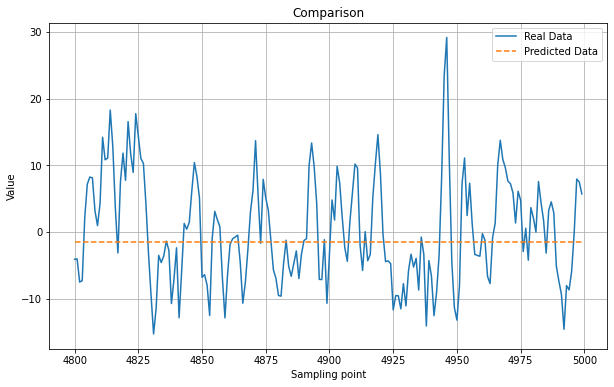

频谱相似度: 0.0271


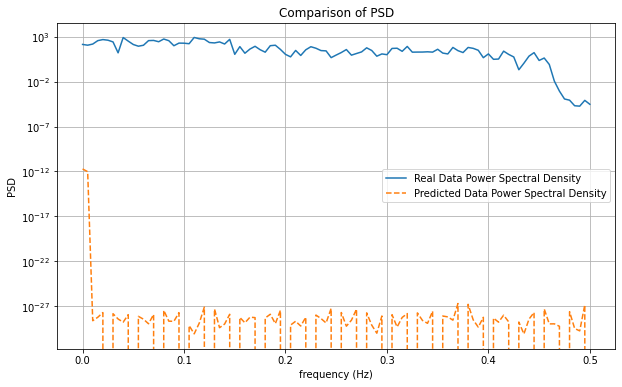

功率谱密度 (PSD) 相似度: 0.0000


In [3]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, MultiHeadAttention, Dropout, LayerNormalization, Add
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据归一化
scaler = MinMaxScaler(feature_range=(-1, 1))  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 Transformer 编码器层
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 多头自注意力
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # 前馈神经网络
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# 构建 Transformer 模型
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    
    # 多层 Transformer 编码器块
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = BatchNormalization()(x)
    x = Dense(mlp_units, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.05 * spectral_loss  # 减少频谱相似度的权重

# 构建模型
model = build_transformer_model(
    input_shape=(n_steps, 1),
    head_size=64,            # 注意力头维度
    num_heads=2,             # 注意力头数
    ff_dim=64,               # 前馈网络维度
    num_transformer_blocks=2, # Transformer 块数
    mlp_units=64,            # MLP 层单元数
    dropout=0.1              # Dropout 比例
)

# 使用 Nadam 优化器（固定较小的学习率）
optimizer = Nadam(learning_rate=0.0003)

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

# 使用固定的验证集来训练和监控
X_val, y_val = X[:960], y[:960]  # 前 20% 作为验证集
X_train, y_train = X[960:], y[960:]

# 模型训练
epochs = 200
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 调整为 Transformer 输入格式
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=epochs, 
    batch_size=32, 
    shuffle=False, 
    verbose=1, 
    callbacks=[early_stopping, lr_scheduler]
)

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4800
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -14120.427
Date:                Sun, 27 Oct 2024   AIC                          28256.855
Time:                        18:43:38   BIC                          28308.664
Sample:                             0   HQIC                         28275.051
                               - 4800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2117      0.014     14.773      0.000       0.184       0.240
ar.L2          0.3957      0.014     27.843      0.000       0.368       0.424
ar.L3          0.0121      0.015      0.794      0.4

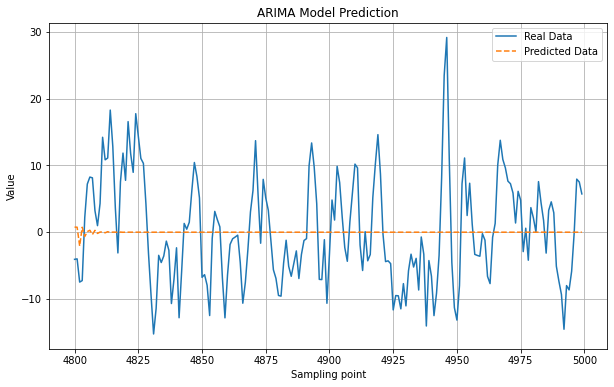

频谱相似度: 0.4623


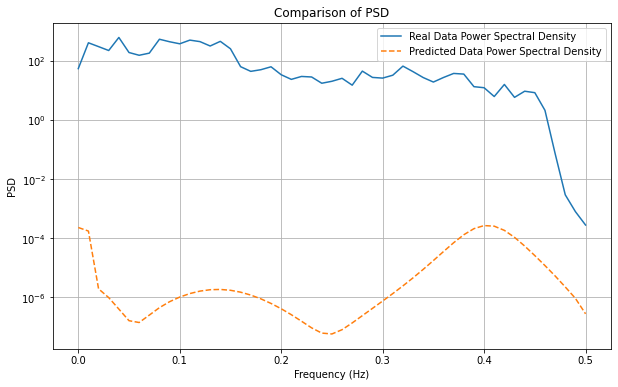

功率谱密度 (PSD) 相似度: 0.1264


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

# 忽略 ARIMA 中的警告
warnings.filterwarnings("ignore")

# 假设 sampled_data 已经存在，包含 5000 个数据点
sampled_data = sampled_data[:5000]  # 保留 5000 个点的数据
train_data, test_data = sampled_data[:4800], sampled_data[4800:]  # 前 4800 个点用于训练，后 200 个点用于测试

# 配置 ARIMA 模型的参数
p = 5  # 自回归项数
d = 1  # 差分项数
q = 2  # 移动平均项数

# 创建并拟合 ARIMA 模型
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# 打印模型摘要
print(model_fit.summary())

# 预测未来 200 个点（即测试集的长度）
predictions = model_fit.forecast(steps=len(test_data))

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制真实数据与预测数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data, label='Real Data')
plt.plot(range(4800, 5000), predictions, label='Predicted Data', linestyle='--')
plt.title('ARIMA Model Prediction')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 频谱相似度计算（选用 FFT）
fft_real = np.fft.fft(test_data)
fft_pred = np.fft.fft(predictions)
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = np.dot(fft_real_abs, fft_pred_abs.T) / (np.linalg.norm(fft_real_abs) * np.linalg.norm(fft_pred_abs))
print(f'频谱相似度: {spectral_similarity[0][0]:.4f}')

# 计算功率谱密度 (PSD)
from scipy.signal import welch
f_real, psd_real = welch(test_data, fs=1.0, nperseg=100)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predictions, fs=1.0, nperseg=100)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度 (PSD) 相似度
from sklearn.metrics.pairwise import cosine_similarity
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 固定随机种子
np.random.seed(42)
tf.random.set_seed(42)

# 假设 sampled_data 是 5000 个点的时间序列数据
sampled_data = sampled_data[:5000]
train_data, test_data = sampled_data[:4800], sampled_data[4800:]

# 使用指数平滑对训练数据进行趋势和季节性分离
es_model = ExponentialSmoothing(train_data, seasonal="add", seasonal_periods=50).fit()
trend_seasonal = es_model.fittedvalues  # 提取指数平滑的趋势和季节性成分
residuals = train_data - trend_seasonal  # 计算残差

# 准备 RNN 输入
n_steps = 50  # 时间步长
X, y = [], []
for i in range(len(residuals) - n_steps):
    X.append(residuals[i:i + n_steps])
    y.append(residuals[i + n_steps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 构建 LSTM 模型作为 RNN
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 训练模型
history = model.fit(X, y, epochs=50, batch_size=32, verbose=1)

# 用训练好的模型预测未来 200 个点
X_input = residuals[-n_steps:].reshape((1, n_steps, 1))
predicted_residuals = []
for _ in range(200):
    predicted_residual = model.predict(X_input, verbose=0)
    predicted_residuals.append(predicted_residual[0, 0])
    X_input = np.append(X_input[:, 1:, :], [[predicted_residual]], axis=1)

predicted_residuals = np.array(predicted_residuals)

# 将指数平滑的趋势和季节性加回到预测的残差上，得到最终预测结果
predicted_trend_seasonal = es_model.forecast(steps=200)  # 预测趋势和季节性成分
final_predictions = predicted_trend_seasonal + predicted_residuals

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, final_predictions))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data, label='Real Data')
plt.plot(range(4800, 5000), final_predictions, label='Predicted Data', linestyle='--')
plt.title('ES-RNN Model Prediction')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50
149/149 [==============================] - 2s 10ms/step - loss: 42.1248
Epoch 2/50
149/149 [==============================] - 2s 12ms/step - loss: 31.2514
Epoch 3/50
149/149 [==============================] - 2s 16ms/step - loss: 30.1078
Epoch 4/50
149/149 [==============================] - 2s 16ms/step - loss: 29.8997
Epoch 5/50
149/149 [==============================] - 2s 16ms/step - loss: 26.7127
Epoch 6/50
149/149 [==============================] - 2s 15ms/step - loss: 24.5722
Epoch 7/50
149/149 [==============================] - 2s 14ms/step - loss: 22.8351
Epoch 8/50
149/149 [==============================] - 3s 17ms/step - loss: 22.8265
Epoch 9/50
149/149 [==============================] - 2s 17ms/step - loss: 21.5583
Epoch 10/50
149/149 [==============================] - 2s 17ms/step - loss: 20.6781
Epoch 11/50
149/149 [==============================] - 3s 17ms/step - loss: 20.1919
Epoch 12/50
149/149 [==============================] - 2s 16ms/step - loss: 19.8846
E

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)